# Combing data and analysing

The cleaned CSVs obtained from 1_extract_clk_data and 2_extract_ext_data can be combined and used to perform statistical analysis. This notebook does the following

* Joining external and clickstream data
* Adding new features and indices
* Filtering to a subset
* Performing some statistical analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind,pearsonr
from helper_files import checkLinearFit

# Inputs

external_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_ext_data.csv"
internal_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_clk_data.csv"


In [49]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))

# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

for item in qu:
    df['exam_improv_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2015_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2015_'+item]).mean()

# Teacher activity
df['teacher_activity'] = (df.filter(regex='q_lvl_[0-6]_tch|_cor_tch').sum(axis=1)/df['user_id_tch']).fillna(0)
df['teacher_other'] = (df[['add_user','create_group','add_custom_assig','add_assig']].sum(axis=1)/df['user_id_tch']).fillna(0)

# Student activity
df['student_activity'] =  (df.filter(regex='q_lvl_[0-6]_std|_cor_std').sum(axis=1)/df['user_id_std']).fillna(0)
df['student_other'] =  (df[['play_video_std','view_concept_std']].sum(axis=1)/df['user_id_std']).fillna(0)

# ------------------------------------------------------
# CLEANING THE DATA
# ------------------------------------------------------

#  Remove all schools that have no IDACI rating
df = df[pd.notnull(df['IDACI'])]

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Select the schools that have provide all science courses in 2016
df = df[(df['Entries|2016_Biology']>0)&(df['Entries|2016_Physics']>0)&(df['Entries|2016_Chemistry']>0)&(df['Entries|2016_Mathematics']>0)]

# Select only those schools that also provide science courses in 2015
df = df[(df['Entries|2015_Biology']>0)&(df['Entries|2015_Physics']>0)&(df['Entries|2015_Chemistry']>0)&(df['Entries|2015_Mathematics']>0)]

# Remove any unecessary features
df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)

# FURTHER CLEANING

# Print dataframe features
print('Total number of schools:',df.shape[0])
print('Total number of features:',df.shape[1])

# Print the first 5 rows of the dataframe
df.head(5)


Total number of schools: 725
Total number of features: 54


,IDACI,Effectiveness,Teach_quality,L_M_index,PercentageFSM,add_assig,q_lvl_0_tch,create_group,q_lvl_3_tch,view_concept_tch,...,q_lvl_2_cor_std,q_lvl_6_std,exam_improv_Biology,exam_improv_Mathematics,exam_improv_Chemistry,exam_improv_Physics,teacher_activity,teacher_other,student_activity,student_other
URN,,,,,,,,,,,,,,,,,,,,,
100049,5.0,3.0,3.0,3.0,40.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.243966,-0.117200,-0.058570,-0.173454,0.000000,0.000000,0.000000,0.000000
100054,5.0,1.0,1.0,1.0,19.7,26.0,16.0,9.0,0.0,9.0,...,570.0,4.0,-0.075617,-0.063231,0.004101,-0.087845,18.333333,42.333333,476.512195,30.658537
100190,4.0,2.0,2.0,2.0,20.7,6.0,133.0,11.0,39.0,15.0,...,77.0,1.0,0.005374,-0.019282,0.056830,0.013295,98.750000,61.750000,234.768421,3.210526
100192,4.0,2.0,2.0,2.0,22.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.092524,-0.042368,-0.139522,-0.003901,0.000000,0.000000,0.000000,0.000000
100279,4.0,2.0,2.0,2.0,21.2,3.0,9.0,3.0,10.0,1.0,...,50.0,0.0,0.088169,-0.027284,0.058434,0.077753,65.000000,76.000000,69.075472,25.018868


## Statistical Analysis

Perform some statistical analysis on the dataset. This is seperated into 

* Evaluating correlation and their respective p values
* Evaluating difference in mean between 2 populations (active IP users and non-active users)

### Analysing correlations

Correlationg and their p values can be performed. Important things to note

* Correlation may be different according to method (Pearson, Kendall Tau or Spearman Rank).
* Outliers can affect correlation coefficient.
* The affect of IP may be radically different for different subsets. 


In [28]:
df.corr(method='pearson')['exam_improv_Physics'].sort_values(ascending=False)


exam_improv_Physics        1.000000
exam_improv_Mathematics    0.423956
exam_improv_Chemistry      0.238923
exam_improv_Biology        0.141196
view_hint_tch              0.062178
play_video_tch             0.059314
L_M_index                  0.056632
q_lvl_3_tch                0.050532
q_lvl_1_cor_tch            0.047453
teacher_activity           0.045211
teacher_other              0.044667
q_lvl_4_tch                0.042861
view_concept_tch           0.033389
Teach_quality              0.033340
q_lvl_2_cor_tch            0.032633
Effectiveness              0.031858
q_lvl_5_tch                0.030909
q_lvl_3_cor_tch            0.030082
q_lvl_1_tch                0.029705
view_assig_prog            0.027702
q_lvl_4_cor_tch            0.027139
add_user                   0.025463
create_group               0.025240
user_id_std                0.023645
q_lvl_5_std                0.022166
q_lvl_2_tch                0.020358
q_lvl_6_cor_std            0.020217
add_custom_assig           0

In [29]:
# Calculating p values
feature_to_test = 'teacher_activity'

print('For Biology:',pearsonr(df[feature_to_test],df['exam_improv_Biology']))
print('For Physics:',pearsonr(df[feature_to_test],df['exam_improv_Physics']))
print('For Maths:',pearsonr(df[feature_to_test],df['exam_improv_Mathematics']))
print('For Chem:',pearsonr(df[feature_to_test],df['exam_improv_Chemistry']))

For Biology: (0.02160218855894935, 0.56142861316168435)
For Physics: (0.045211035815149167, 0.22403611678841592)
For Maths: (0.053987352818983175, 0.14644465281254673)
For Chem: (-0.015992872599293793, 0.66726421862457252)


,Coef,R^2,X,Y,intercept
0,0.000019,0.000467,teacher_activity,exam_improv_Biology,-0.001059
1,0.000040,0.002915,teacher_activity,exam_improv_Mathematics,-0.004277
2,-0.000014,0.000256,teacher_activity,exam_improv_Chemistry,-0.004442
3,0.000050,0.002044,teacher_activity,exam_improv_Physics,-0.003115
4,0.000011,0.000020,teacher_other,exam_improv_Biology,-0.000741
5,0.000044,0.000431,teacher_other,exam_improv_Mathematics,-0.003996
6,-0.000014,0.000030,teacher_other,exam_improv_Chemistry,-0.004573
7,0.000144,0.001995,teacher_other,exam_improv_Physics,-0.004446
8,0.000003,0.000091,student_activity,exam_improv_Biology,-0.000995
9,-0.000004,0.000328,student_activity,exam_improv_Mathematics,-0.002401


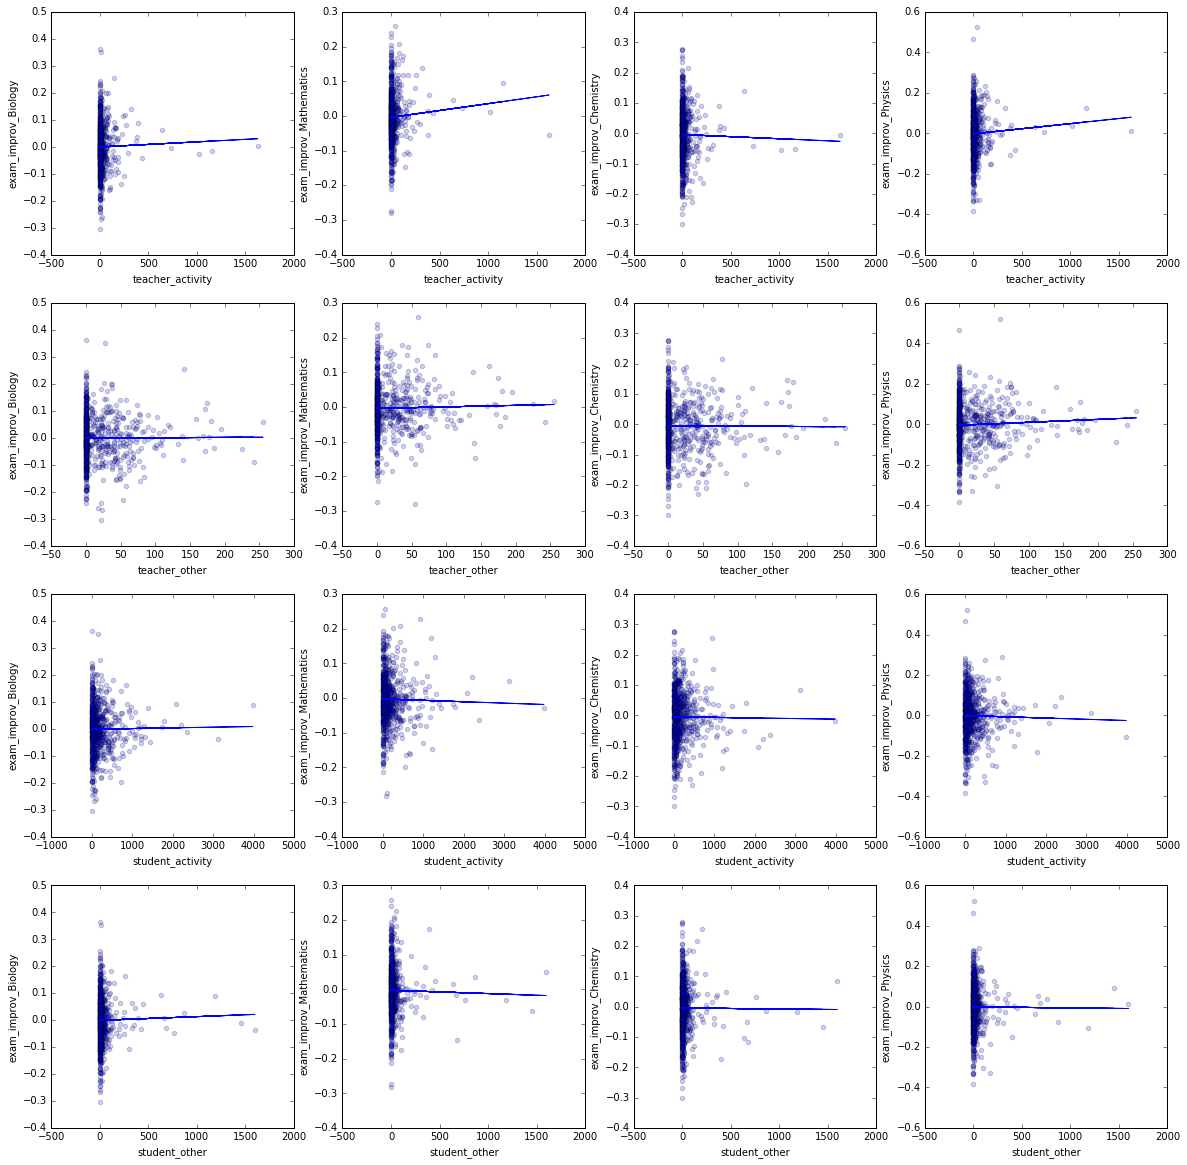

In [30]:
# Checking linear fit and looking for outliers

feature = ['teacher_activity','teacher_other','student_activity','student_other']

df_out = checkLinearFit(df,feature,df.filter(like='exam').columns, n_cols=4, n_rows=4,figsize=(20,20))
df_out

## Analysing Populations

The schools can be binned into 2 seperate populations as active users, non-active users and semi-active users. 
Then the mean difference between the populations can be evaluated with an ANOVA test.  



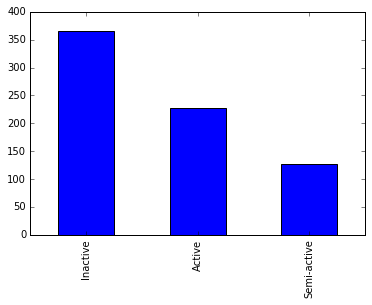

In [79]:
# Bin the schools into seperate categories

# ------------------------------------------------------
# Number of times the teacher has played a video
# ------------------------------------------------------
bins = [-0.1, 1, 100]
group_names = ['Inactive','Active']

df['categories'] = pd.cut(df['play_video_tch'],bins, labels=group_names)

# ------------------------------------------------------
# Some other teacher feature
# ------------------------------------------------------
bins = [-0.1, 0, 10,1000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = pd.cut(df['teacher_activity'],bins, labels=group_names)

# Plot a histogram
df['categories'].value_counts().plot(kind='bar')

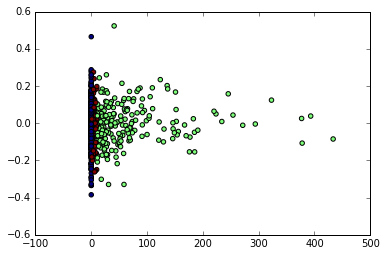

In [80]:
# Plotting a scatter plot to visualise any clusters

colors = pd.factorize(df['categories'])[0]
plt.scatter(df['teacher_activity'],df['exam_improv_Physics'],c=colors)

Mean of inactive: -0.005427645561510453
Mean of active: 0.002611517241386947


Ttest_indResult(statistic=-0.83613902193053102, pvalue=0.40345219049860392)

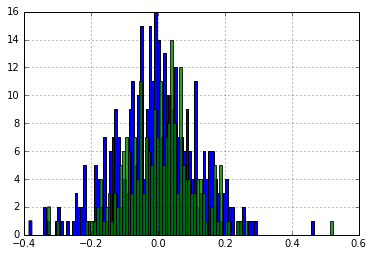

In [60]:
# Plot the histograms of the 2 populations and do a t-test

feature = 'exam_improv_Physics'

df[df['categories']=='Inactive'][feature].hist(bins=100)
df[df['categories']=='Active'][feature].hist(alpha=0.8,bins=100)

print('Mean of inactive:',df[df['categories']=='Inactive'][feature].mean())
print('Mean of active:',df[df['categories']=='Active'][feature].mean())

ttest_ind(df[df['categories']=='Inactive'][feature],df[df['categories']=='Active'][feature],equal_var=False)


In [67]:
# Doing an F-test on all variables of interest

from sklearn.feature_selection import f_classif


df_test = df[df['categories']!= 'Semi-active']

X = df_test.filter(regex='exam_improv')
y = [1 if item == 'Active' else 0 for item in df_test['categories']]
print('Keys:',X.keys())
F, pval = f_classif(X, y)
print('F score is ',F)
print('Corresponding p values',pval)

Keys: Index(['exam_improv_Biology', 'exam_improv_Mathematics',
       'exam_improv_Chemistry', 'exam_improv_Physics'],
      dtype='object')
F score is  [ 0.14376748  0.20674408  0.83948543  0.58072121]
Corresponding p values [ 0.70469926  0.64949726  0.35991518  0.44633173]
